In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

In [2]:
weekly = pd.read_csv('../data/Weekly.csv', index_col=0)
weekly.head()

Year   Lag1   Lag2   Lag3   Lag4   Lag5    Volume  Today Direction
1  1990  0.816  1.572 -3.936 -0.229 -3.484  0.154976 -0.270      Down
2  1990 -0.270  0.816  1.572 -3.936 -0.229  0.148574 -2.576      Down
3  1990 -2.576 -0.270  0.816  1.572 -3.936  0.159837  3.514        Up
4  1990  3.514 -2.576 -0.270  0.816  1.572  0.161630  0.712        Up
5  1990  0.712  3.514 -2.576 -0.270  0.816  0.153728  1.178        Up

In [3]:
weekly.describe()

Year         Lag1         Lag2         Lag3         Lag4  \
count  1089.000000  1089.000000  1089.000000  1089.000000  1089.000000   
mean   2000.048669     0.150585     0.151079     0.147205     0.145818   
std       6.033182     2.357013     2.357254     2.360502     2.360279   
min    1990.000000   -18.195000   -18.195000   -18.195000   -18.195000   
25%    1995.000000    -1.154000    -1.154000    -1.158000    -1.158000   
50%    2000.000000     0.241000     0.241000     0.241000     0.238000   
75%    2005.000000     1.405000     1.409000     1.409000     1.409000   
max    2010.000000    12.026000    12.026000    12.026000    12.026000   

              Lag5       Volume        Today  
count  1089.000000  1089.000000  1089.000000  
mean      0.139893     1.574618     0.149899  
std       2.361285     1.686636     2.356927  
min     -18.195000     0.087465   -18.195000  
25%      -1.166000     0.332022    -1.154000  
50%       0.234000     1.002680     0.241000  
75%       1.405000     2.053727     1.405000  
max      12.026000     9.328214    12.026000

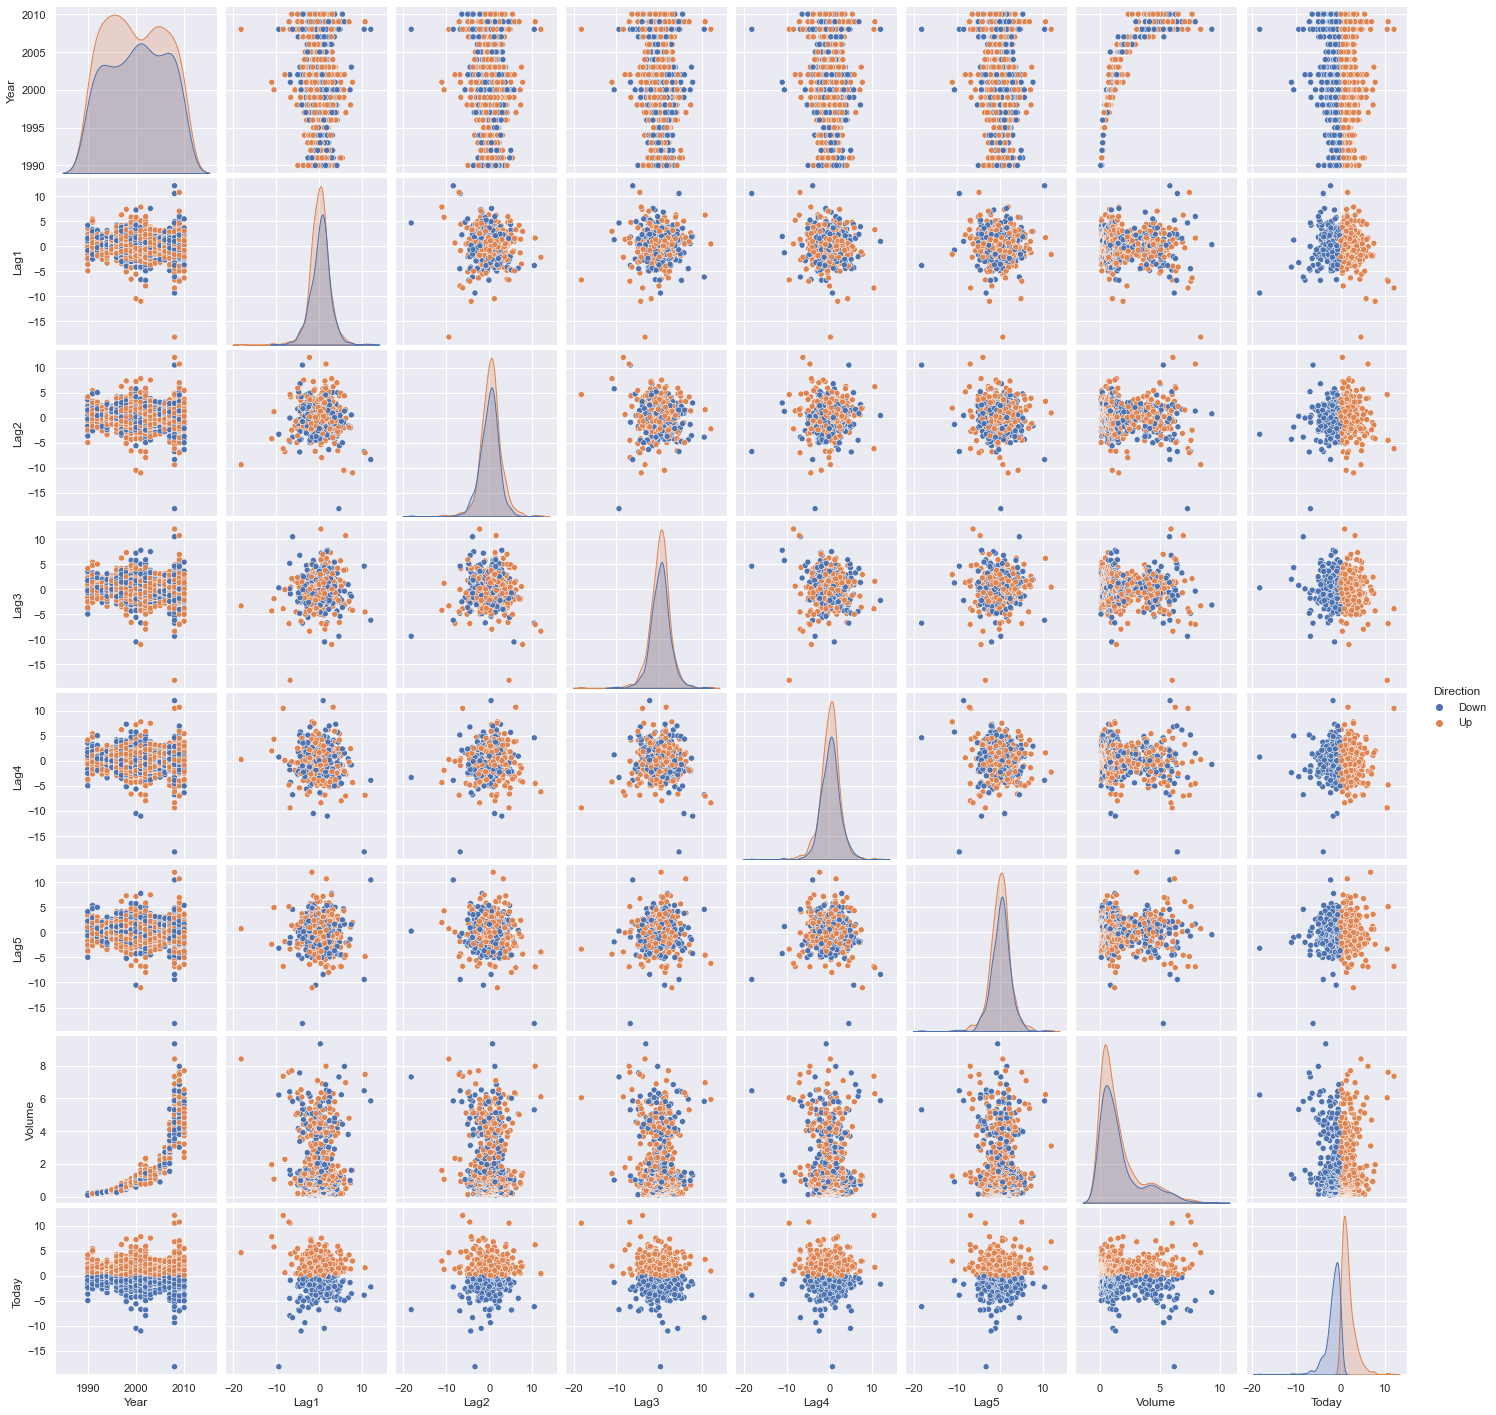

In [4]:
sns.pairplot(weekly, hue='Direction');

### 10.a
1. The Lag* variables seem to be normal distributed, with mean 0.
2. There seem to be more Up weeks than Down weeks (looking at the diagonal). Verify this. 
3. There was never an year where Down weeks were more than Up weeks (see Year vs. Year). 
4. The Lag* variables seem to be uncorrelated with each other & Today.
5. Volume is positively correlated with year.

In [5]:
sns.heatmap(weekly.corr(), annot=True);

In [6]:
# for each year, how many Up and Down weeks?
gpby_year = weekly.groupby(by=['Year', 'Direction']).agg(
    {'Direction': np.size,
     'Today': np.mean})
gpby_year.head()
# TODO: read up on groupby and multi-index from PDSH and finish this. 

Direction     Today
Year Direction                     
1990 Down              23 -1.914130
     Up                24  1.719042
1991 Down              21 -1.265238
     Up                31  1.750355
1992 Down              23 -1.039217

In [7]:
# total number of Up and Down weeks
n_down_weeks = np.sum(weekly.Direction == 'Down')
n_up_weeks = np.sum(weekly.Direction == 'Up')
n_down_weeks, n_up_weeks

(484, 605)

### 10.b Logistic regression

In [8]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

weekly['Direction2'] = weekly.Direction.map({'Down': 0, 'Up': 1})
formula = 'Direction2 ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume'
sm_logit = smf.logit(formula, weekly).fit()
print(sm_logit.summary())

Optimization terminated successfully.
         Current function value: 0.682441
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:             Direction2   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1082
Method:                           MLE   Df Model:                            6
Date:                Tue, 22 Dec 2020   Pseudo R-squ.:                0.006580
Time:                        12:42:03   Log-Likelihood:                -743.18
converged:                       True   LL-Null:                       -748.10
Covariance Type:            nonrobust   LLR p-value:                    0.1313
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2669      0.086      3.106      0.002       0.098       0.435
Lag1          -0.0413      0.

- Lag2 appears significant, both from the summary above and correlation heatmap.
    - when Lag2 was Up, Today tends to be Up?
- Lag3-5 & Volume don't appear to be significant.
- Lag1 is next significant after Lag2.

### 10.c Confusion matrix

In [9]:
sm_logit.pred_table()

array([[ 54., 430.],
       [ 48., 557.]])

In [10]:
# fraction of correct, wrong predictions
(54 + 557) / (54 + 430 + 48 + 557), (430 + 48) / (54 + 430 + 48 + 557)

(0.5610651974288338, 0.4389348025711662)

1. Sensitivity (fraction of true positives) is fine, however, the model is predicting a lot of false positives.

In [11]:
sm_logit.pred_table(threshold=0.55) # raising the threshold help decrease false positives, but increases false negatives

array([[228., 256.],
       [242., 363.]])

### 10.d

In [12]:
from sklearn.metrics import confusion_matrix

mask = (weekly.Year < 2009)
train = weekly[mask]
test = weekly[~mask]
clf = smf.logit('Direction2 ~ Lag2', train).fit()
probs = clf.predict(test)
preds = (probs > .5)
confusion_matrix(test.Direction2, preds)

Optimization terminated successfully.
         Current function value: 0.685555
         Iterations 4


array([[ 9, 34],
       [ 5, 56]], dtype=int64)

In [13]:
# fraction of correct predictions
np.mean(test.Direction2 == preds), (56 + 9) / (9 + 34 + 5 + 56)

(0.625, 0.625)

### 10.e LDA

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

X_train, X_test = train[['Lag2']], test[['Lag2']]
y_train, y_test = train['Direction2'], test['Direction2']

lda = LinearDiscriminantAnalysis().fit(X_train, y_train)
lda_preds = lda.predict(X_test)
confusion_matrix(y_test, lda_preds)

array([[ 9, 34],
       [ 5, 56]], dtype=int64)

### 10.f QDA

In [15]:
qda = QuadraticDiscriminantAnalysis().fit(X_train, y_train)
qda_preds = lda.predict(X_test)
confusion_matrix(y_test, qda_preds)

array([[ 9, 34],
       [ 5, 56]], dtype=int64)

### 10.g Knn (k=1)

In [16]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
knn_preds = knn.predict(X_test)
confusion_matrix(y_test, knn_preds)

array([[21, 22],
       [31, 30]], dtype=int64)

In [17]:
# fraction of correct predicitons
np.mean(y_test == knn_preds)

0.49038461538461536

### 10.h 
logistic, lda, qda models all seem to preform about the same (correct rate = 0.625) & knn (k=1) seems to be the worse.

In [18]:
### 10.i
# TODO

## 11 Auto data set

In [19]:
auto = pd.read_csv('../data/Auto.csv', na_values='?').dropna()
auto.head()

mpg  cylinders  displacement  horsepower  weight  acceleration  year  \
0  18.0          8         307.0       130.0    3504          12.0    70   
1  15.0          8         350.0       165.0    3693          11.5    70   
2  18.0          8         318.0       150.0    3436          11.0    70   
3  16.0          8         304.0       150.0    3433          12.0    70   
4  17.0          8         302.0       140.0    3449          10.5    70   

   origin                       name  
0       1  chevrolet chevelle malibu  
1       1          buick skylark 320  
2       1         plymouth satellite  
3       1              amc rebel sst  
4       1                ford torino

### 11.a mpg as a categorial (or ordinal?) variable

In [20]:
mpg_median = np.median(auto.mpg)
auto['mpg01'] = (auto.mpg > mpg_median).astype(int)
auto.head()

mpg  cylinders  displacement  horsepower  weight  acceleration  year  \
0  18.0          8         307.0       130.0    3504          12.0    70   
1  15.0          8         350.0       165.0    3693          11.5    70   
2  18.0          8         318.0       150.0    3436          11.0    70   
3  16.0          8         304.0       150.0    3433          12.0    70   
4  17.0          8         302.0       140.0    3449          10.5    70   

   origin                       name  mpg01  
0       1  chevrolet chevelle malibu      0  
1       1          buick skylark 320      0  
2       1         plymouth satellite      0  
3       1              amc rebel sst      0  
4       1                ford torino      0

In [21]:
mpg_median

23.0

### 11.b EDA

In [22]:
sns.pairplot(auto, hue='mpg01');

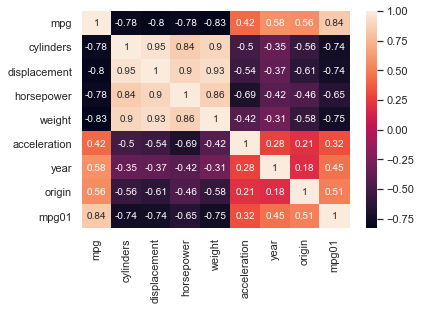

In [23]:
sns.heatmap(auto.corr(), annot=True);

NOTES:
1. cylinders, displacement, horsepower, weight seem to be correlated with each other.
    - all these seem to be negatively correlated with mpg.
2. acceleration, year, origin seem to be positively correlated with mpg. 
3. acceleration and year seem to be negatively correlated with cylinders, dispalcement, horsepower, weight.
    - acceleration makes sense, but year? 

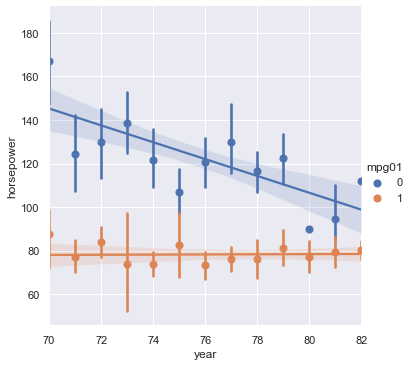

In [24]:
sns.lmplot(x='year', y='horsepower', data=auto, x_estimator=np.mean, hue='mpg01');

In [25]:
sns.lmplot(x='year', y='weight', data=auto, x_estimator=np.mean, hue='mpg01');

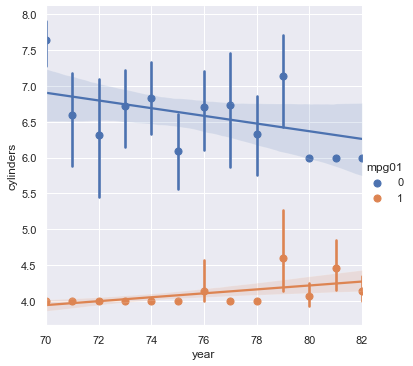

In [26]:
sns.lmplot(x='year', y='cylinders', data=auto, x_estimator=np.mean, hue='mpg01');

### 11.c train and test splits

In [50]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(auto, test_size=0.2, random_state=42, stratify=auto.mpg01)
train.shape, test.shape

((313, 10), (79, 10))

### 11.f logistic regression on auto data set for predicting categoriacal variable mpg01

In [52]:
import statsmodels.formula.api as smf
import patsy

features = ' + '.join(auto.columns.tolist()[1:-2]) # drop mpg & name
print('The chosen features are: ', features)
formula = 'mpg01 ~ ' + features
clf = smf.logit(formula, train).fit()
print(clf.summary())

The chosen features are:  cylinders + displacement + horsepower + weight + acceleration + year + origin
Optimization terminated successfully.
         Current function value: 0.192399
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  mpg01   No. Observations:                  313
Model:                          Logit   Df Residuals:                      305
Method:                           MLE   Df Model:                            7
Date:                Tue, 22 Dec 2020   Pseudo R-squ.:                  0.7220
Time:                        14:04:28   Log-Likelihood:                -60.221
converged:                       True   LL-Null:                       -216.60
Covariance Type:            nonrobust   LLR p-value:                 1.143e-63
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------


In [53]:
from sklearn.metrics import confusion_matrix

probs = clf.predict(test)
preds = (probs > .5)
confusion_matrix(test.mpg01, preds)

array([[38,  3],
       [ 4, 34]], dtype=int64)

In [59]:
# dropping insignificant variables from above
formula2 = 'mpg01 ~ horsepower + weight + year'
clf = smf.logit(formula2, train).fit()
print(clf.summary())
probs = clf.predict(test)
preds = (probs > .5)
confusion_matrix(test.mpg01, preds)

Optimization terminated successfully.
         Current function value: 0.193921
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  mpg01   No. Observations:                  313
Model:                          Logit   Df Residuals:                      309
Method:                           MLE   Df Model:                            3
Date:                Tue, 22 Dec 2020   Pseudo R-squ.:                  0.7198
Time:                        14:10:30   Log-Likelihood:                -60.697
converged:                       True   LL-Null:                       -216.60
Covariance Type:            nonrobust   LLR p-value:                 2.783e-67
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -24.2479      5.899     -4.110      0.000     -35.810     -12.686
horsepower    -0.0175      0.

array([[38,  3],
       [ 4, 34]], dtype=int64)

### 11.d LDA

In [75]:
y_train, X_train = patsy.dmatrices(formula2, data=train)
y_test, X_test = patsy.dmatrices(formula2, data=test)
print(y_train.shape, X_train.shape, y_test.shape, X_test.shape)
lda = LinearDiscriminantAnalysis().fit(X_train, y_train.ravel())
probs = lda.predict(X_test)
preds = (probs > .5)
print(confusion_matrix(y_test, preds))
print('The test error rate is: ', np.mean(y_test.ravel() != preds))

(313, 1) (313, 4) (79, 1) (79, 4)
[[36  5]
 [ 3 35]]
The test error rate is:  0.10126582278481013


### 11.e QDA

In [76]:
qda = LinearDiscriminantAnalysis().fit(X_train, y_train.ravel())
probs = qda.predict(X_test)
preds = (probs > .5)
print(confusion_matrix(y_test, preds))
print('The test error rate is: ', np.mean(y_test.ravel() != preds))

[[36  5]
 [ 3 35]]
The test error rate is:  0.10126582278481013


In [74]:
y_test.ravel()

array([0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1.,
       1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
       1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1.])

### 11.f KNN with different k

In [77]:
from sklearn.model_selection import cross_validate
# TODO

## 12 
involves writing simple functions, so skipping. 

## 13 Boston data set

In [79]:
boston = pd.read_csv('../data/Boston.csv', index_col=0).dropna()
boston.head()

crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
1  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
2  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
3  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
4  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
5  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

    black  lstat  medv  
1  396.90   4.98  24.0  
2  396.90   9.14  21.6  
3  392.83   4.03  34.7  
4  394.63   2.94  33.4  
5  396.90   5.33  36.2

In [80]:
# create two dummy variables cr & cr2 to encode crime rate
median_crime_rate = np.median(boston.crim)
boston['cr2'] = (boston.crim > median_crime_rate).astype(int)
boston['cr'] = boston.cr2.map({1: 'High', 0: 'Low'})
boston.head()

crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
1  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
2  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
3  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
4  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
5  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

    black  lstat  medv  cr2   cr  
1  396.90   4.98  24.0    0  Low  
2  396.90   9.14  21.6    0  Low  
3  392.83   4.03  34.7    0  Low  
4  394.63   2.94  33.4    0  Low  
5  396.90   5.33  36.2    0  Low

In [85]:
plt.figure(figsize=(12,12))
sns.heatmap(boston.corr(), annot=True);

In [116]:
sns.pairplot(boston.drop(columns=['cr2']), hue='cr');

#### Logistic regression

In [90]:
train, test = train_test_split(boston, test_size=0.2, random_state=42, stratify=boston.cr)
print(train.shape, test.shape)

(404, 16) (102, 16)


In [89]:
' + '.join(boston.columns)

'crim + zn + indus + chas + nox + rm + age + dis + rad + tax + ptratio + black + lstat + medv + cr2 + cr'

In [96]:
formula = 'cr2 ~ zn + indus + chas + nox + rm + age + dis + rad + tax + ptratio + black + lstat + medv'
# running this cells a few iterations to figure out significant predictors
# iter 1: rm is insignificant, drop it
formula = 'cr2 ~ zn + indus + chas + nox + age + dis + rad + tax + ptratio + black + lstat + medv'
# iter 2: indus and chas are insignificant. indus is correlated to dis and zn. Let's look at interactions
formula = 'cr2 ~ zn + indus + chas + nox + age + dis + rad + tax + ptratio + black + lstat + medv + indus*zn + indus*dis'
# iter 3: zn, chas and dis are insignificant. rest all are significant. 
formula = 'cr2 ~ indus + nox + age + rad + tax + ptratio + black + lstat + medv + indus:zn + indus:dis'

clf = smf.logit(formula, data=train)
res = clf.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.167628
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                    cr2   No. Observations:                  404
Model:                          Logit   Df Residuals:                      392
Method:                           MLE   Df Model:                           11
Date:                Tue, 22 Dec 2020   Pseudo R-squ.:                  0.7582
Time:                        17:35:47   Log-Likelihood:                -67.722
converged:                       True   LL-Null:                       -280.03
Covariance Type:            nonrobust   LLR p-value:                 3.604e-84
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -55.4734      9.334     -5.943      0.000     -73.767     -37.180
indus         -0.3827      0

In [97]:
res.pred_table()

array([[190.,  12.],
       [ 17., 185.]])

In [102]:
# train error rate
np.mean(train.cr2 != (res.predict() > .5)), (12 + 17) / (190 + 12 + 17 + 185)

(0.07178217821782178, 0.07178217821782178)

In [104]:
# test error rate
probs = res.predict(test)
preds = (probs > .5)
print(confusion_matrix(test.cr2, preds))
print('Test error rate: ', np.mean(test.cr2 != preds))

[[43  8]
 [ 7 44]]
Test error rate:  0.14705882352941177


In [111]:
y_train, X_train = patsy.dmatrices(formula, data=train, return_type='matrix')
y_test, X_test = patsy.dmatrices(formula, data=test, return_type='matrix')
y_train, y_test = y_train.ravel(), y_test.ravel()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(404, 12) (404,) (102, 12) (102,)


In [121]:
X_train[:5, 1:].shape

(5, 11)

In [124]:
lda = LinearDiscriminantAnalysis().fit(X_train, y_train)
lda_preds = lda.predict(X_test)
print(confusion_matrix(y_test, lda_preds))
print('LDA test error rate: ', np.mean(y_test != lda_preds))

[[47  4]
 [14 37]]
LDA test error rate:  0.17647058823529413


In [123]:
# QDA
# QDA errors out with the intercept term; i don't know why!!
lda = QuadraticDiscriminantAnalysis().fit(X_train[:, 1:], y_train)
lda_preds = lda.predict(X_test[:, 1:])
print(confusion_matrix(y_test, lda_preds))
print('LDA test error rate: ', np.mean(y_test != lda_preds))

[[50  1]
 [ 6 45]]
LDA test error rate:  0.06862745098039216


In [128]:
# knn
lda = KNeighborsClassifier(n_neighbors=3).fit(X_train[:, 1:], y_train)
lda_preds = lda.predict(X_test[:, 1:])
print(confusion_matrix(y_test, lda_preds))
print('LDA test error rate: ', np.mean(y_test != lda_preds))

[[49  2]
 [ 3 48]]
LDA test error rate:  0.049019607843137254


Some observations:
1. knn gives the least test error rate, followed by QDA, logistic & LDA.
2. the decision boundary might by highly non-linear. Is there a way to visualize this?